# Big Iron

See <a href="https://www.kaggle.com/competitions/bluebook-for-bulldozers/leaderboard">Blue Book for Bulldozers</a> leaderboard page.

BTW this notebook borrows heavily from <a href="https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb">chapter 9</a> of
<a href="https://github.com/fastai/fastbook">Fastai's FastBook.
    
<mark>Fastai also has a set of <a href="https://www.fast.ai/posts/2022-07-21-dl-coders-22.html">online courses</a> and librarys (see below) designed to show regular people how to apply advanced machine and deep learning algorithms to real world problems.  Its extremely applied and fortunately, much of the complexity is handled by the library itself.  
    
<b>It is the best course I know of for teaching AI, Machine Learning and Data Science.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)
    
import utils as ut

#want to use a subset of the data?
use_latest=False
latest_size=200000

<mark>install fastai

In [2]:
#install fastai library
# !pip install fastai
#or see https://pypi.org/project/fastai/

# Get the data

In [3]:
#install kaggle api
# !pip install kaggle

In [4]:
#if you have the Kaggle api installed then use it
!kaggle competitions download -c bluebook-for-bulldozers

bluebook-for-bulldozers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#uhoh...my key is exposed, get your key from kaggle place it in the noted folder
!chmod 600 /home/keith/.kaggle/kaggle.json

# EDA  
git restore --staged homework/data/TrainAndValid.csv

In [6]:
df=pd.read_csv('./data/TrainAndValid.csv')
print(df.shape)

(412698, 53)


/tmp/ipykernel_550095/1701633161.py:1: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('./data/TrainAndValid.csv')


In [7]:
df.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
saledate                     object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                

In [8]:
df.Blade_Extension.unique()

array([nan, 'Yes', 'None or Unspecified'], dtype=object)

In [9]:
#Is a column mostly full of NaN's?
for c in df.columns:
    if df[c].isnull().sum()/len(df) > 0.9:
        print(f"Column {c} has more than 90% missing values.")
        # df.drop(c, axis=1, inplace=True)

Column Blade_Extension has more than 90% missing values.
Column Blade_Width has more than 90% missing values.
Column Enclosure_Type has more than 90% missing values.
Column Engine_Horsepower has more than 90% missing values.
Column Pushblock has more than 90% missing values.
Column Scarifier has more than 90% missing values.
Column Tip_Control has more than 90% missing values.


In [10]:
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06


In [11]:
df.YearMade[df.YearMade ==1000].count()

39391

### Note the sale date, this is a time series problem, that changes how we split the data into train and validation set (cannot use random splitter)

To split: Older data is training data, Newer data is validation data.  This keeps information from leaking from the validation set back to the training set.

### Lets see what the date range is

In [12]:
df['saledate']=pd.to_datetime(df['saledate'])

In [13]:
print(f'earliest date= {df.saledate.min()}, latest date={df.saledate.max()}')

earliest date= 1989-01-17 00:00:00, latest date=2012-04-28 00:00:00


### Sort the dataframe by saledate in preparation for splitting into train and validation sets
<mark> train on oldest, test on newest

In [14]:
#how muchmemory am I using?
import psutil

process = psutil.Process()
memory_usage = process.memory_info().rss / (1024 ** 2)  # Convert bytes to MB
print(f"Memory usage: {memory_usage:.2f} MB")

Memory usage: 435.63 MB


In [15]:
df.sort_values(by=['saledate'], inplace=True)

#want to use a subset?
if(use_latest):
    df=df[-latest_size:]
len(df)

412698

### Add a Time field for the Linear regressor that we will use to subtract the trend

In [16]:
dates=pd.DatetimeIndex(df.saledate)
df['Time']=[(dates[i]-dates[0]).days for i in range(len(df))]
df['Time']
# df[['saledate','Time']].head(20)

205615       0
274835      14
141296      14
212552      14
62755       14
          ... 
410879    8502
412476    8502
411927    8502
407124    8502
409203    8502
Name: Time, Length: 412698, dtype: int64

## <mark>Hmmm.. this dataset has sales around 2007, when the almost great depression hit

I wonder if a vix entry would help?  Goto <a href="https://www.macrotrends.net/2603/vix-volatility-index-historical-chart">VIX Volatility Index - Historical Chart</a> to grab this data, get all years and download the csv.  See if it helps, if so keep it, if not dont.
    
While we are at it. Lets get a few more: 
    
1.<a href="https://www.macrotrends.net/2534/wheat-prices-historical-chart-data">Wheat Prices - 40 Year Historical Chart</a><br>
2.<a href="https://www.macrotrends.net/2015/fed-funds-rate-historical-chart">Federal Funds Rate - 62 Year Historical Chart</a>  

In [17]:
fed=pd.read_csv('fed-funds-rate-historical-chart.csv',skiprows=15)
# print(f" length={len(fed)}, NaNs in value={fed.loc[:,' value'].isnull().sum()}")
print(f" length={len(fed)}, NaNs in value={fed.loc[:-21,' value'].isnull().sum()}")

 length=24592, NaNs in value=0


In [18]:
fed

,date,value
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88
...,...,...
24587,2023-05-06,NaN
24588,2023-05-07,NaN
24589,2023-05-08,NaN
24590,2023-05-09,NaN


In [19]:
#create a little function to preprocess, scale and add to df
from sklearn.preprocessing import StandardScaler
def get_df(df,filename,new_col_name):
    dfn=pd.read_csv(filename,skiprows=15)
    dfn['date'] =  pd.to_datetime(dfn['date'])
    dfn.rename(columns={' value':new_col_name},inplace=True)
    
    #scale it
    dfn[new_col_name]=StandardScaler().fit_transform(dfn[[new_col_name]])
    
    #now merge
    df = pd.merge(df,dfn, left_on='saledate', right_on='date', how='left')
    df.drop(columns=['date'],inplace=True)
    df[new_col_name].fillna(method='backfill',inplace=True)
    df[new_col_name].fillna(method='ffill',inplace=True)
    return df

#the following 2 did not help, the last one did though
# df=get_df(df,'./vix-volatility-index-historical-chart.csv','vix')
# df=get_df(df,'./wheat-prices-historical-chart-data.csv','wheat')
# get_df(df,'./fed-funds-rate-historical-chart.csv','fedrate')
df=get_df(df,'./fed-funds-rate-historical-chart.csv','fedrate')
# df

## <mark>Split Dates into more useful features

Its hard for a random forest to use a datetime object since it has a lot of encoded information (the year,the month, the day of the week, weekday, weekend, holiday, end of quarter etc.).  We can slog through and manually create these features, or use fastai, a library that already does this.

In [20]:
orig=list(df.columns)

In [21]:
#using a fastai helper function to get ALL the date info
from fastai.tabular import core
df = core.add_datepart(df, 'saledate')

#look at all those additional sale columns
[col for col in df.columns if 'sale' in col]

['saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleElapsed']

In [22]:
new=list(df.columns)
[col for col in new if col not in orig]

['saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleElapsed']

Any obvious outliers?

In [23]:
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,Time,fedrate,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,4.126980e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03,5754.079366,-0.523997,2004.317382,6.300268,25.721191,16.152894,2.594338,176.784094,1.098151e+09
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04,2123.225527,0.656658,5.821090,3.437276,14.841265,8.429510,1.417971,103.910718,1.834467e+08
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,0.000000,-1.274952,1989.000000,1.000000,1.000000,1.000000,0.000000,1.000000,6.009984e+08
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00,4341.000000,-1.233628,2000.000000,3.000000,12.000000,9.000000,2.000000,82.000000,9.760608e+08
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00,6371.000000,-0.674370,2006.000000,6.000000,24.000000,16.000000,3.000000,165.000000,1.151453e+09
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03,7436.000000,0.141099,2009.000000,9.000000,39.000000,23.000000,3.000000,270.000000,1.243469e+09
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06,8502.000000,1.518581,2012.000000,12.000000,53.000000,31.000000,6.000000,365.000000,1.335571e+09


In [24]:
df.saleYear.max()
df[df.YearMade<1900]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Time,fedrate,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
4168,1601392,16500.0,1137322,30689,132,24.0,1000,NaN,NaN,415,415,NaN,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,Georgia,BL,Backhoe Loaders,Two Wheel Drive,OROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294,1.094317,1989,11,45,7,1,311,False,False,False,False,False,False,6.264000e+08
11861,1264896,13000.0,1231366,6788,132,1.0,1000,NaN,NaN,580,580,NaN,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,Arizona,BL,Backhoe Loaders,Two Wheel Drive,OROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,849,0.336702,1991,5,20,16,3,136,False,False,False,False,False,False,6.743520e+08
26297,1746002,23000.0,1313837,27000,132,23.0,1000,2399.0,Low,D31E18,D31,E,18,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horsepower",New Jersey,TTT,Track Type Tractors,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,2 Pedal,NaN,NaN,1824,-0.473258,1994,1,2,15,5,15,False,False,False,False,False,False,7.585920e+08
26306,1739008,22500.0,1296481,2219,132,23.0,1000,NaN,NaN,PC200-3LC,PC200,NaN,-3LC,NaN,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons",New Jersey,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,1824,-0.473258,1994,1,2,15,5,15,False,False,False,False,False,False,7.585920e+08
26308,1731124,47000.0,1134693,632,132,23.0,1000,NaN,NaN,WA450-1,WA450,NaN,-1,NaN,Medium,Wheel Loader - 250.0 to 275.0 Horsepower,New Jersey,WL,Wheel Loader,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Base + 1 Function,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,1824,-0.473258,1994,1,2,15,5,15,False,False,False,False,False,False,7.585920e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412665,6298418,15500.0,1905393,24817,149,99.0,1000,NaN,NaN,2173,217,NaN,3,NaN,NaN,Backhoe Loader - 16.0 + Ft Standard Digging Depth,California,BL,Backhoe Loaders,Four Wheel Drive,OROPS,None or Unspecified,None or Unspecified,No,Extended,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8502,-1.250158,2012,4,17,28,5,119,False,False,False,False,False,False,1.335571e+09
412666,6310222,5000.0,1846527,9548,149,99.0,1000,NaN,NaN,743,743,NaN,NaN,NaN,NaN,Skid Steer Loader - 1251.0 to 1351.0 Lb Operating Capacity,California,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,Na

### <mark>YearMade has some tractors made in the year 1000, how to fix this?

<Axes: xlabel='YearMade', ylabel='Count'>

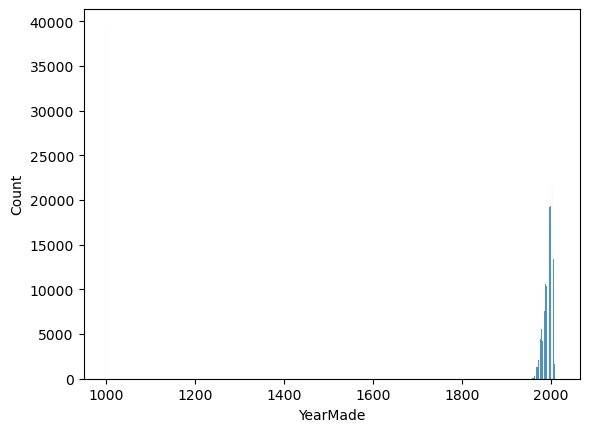

In [25]:
sns.histplot(df,x='YearMade')

## Lets try to infer bogus YearMades (==1000)

In [26]:
#how many made before 1300?
df.loc[df.YearMade==1000].shape[0]

39391

In [27]:
for c in df.columns:
    if df[c].isnull().sum()==0:
        print(f'{c}: {df[c].nunique()}')

SalesID: 412698
SalePrice: 954
MachineID: 348808
ModelID: 5281
datasource: 6
YearMade: 73
fiModelDesc: 5059
fiBaseModel: 1961
fiProductClassDesc: 74
state: 53
ProductGroup: 6
ProductGroupDesc: 6
Time: 4013
fedrate: 655
saleYear: 24
saleMonth: 12
saleWeek: 53
saleDay: 31
saleDayofweek: 7
saleDayofyear: 361
saleIs_month_end: 2
saleIs_month_start: 2
saleIs_quarter_end: 2
saleIs_quarter_start: 2
saleIs_year_end: 2
saleIs_year_start: 2
saleElapsed: 4013


In [28]:
#look for good columns to groupby, dont use ones with a lot of NaNs or too many/few values
# df.nunique().sort_values()
# df.select_dtypes(include=['object'])
# df.select_dtypes(include=['object']).dtypes

In [29]:
#find good columns to groupby
tmp=df.loc[:,['fiModelDesc','ModelID','fiBaseModel','fiModelSeries','fiModelDescriptor','fiProductClassDesc']]

# #want few nulls
tmp.isnull().sum()

fiModelDesc                0
ModelID                    0
fiBaseModel                0
fiModelSeries         354031
fiModelDescriptor     337882
fiProductClassDesc         0
dtype: int64

In [30]:
df.ModelID.nunique()

5281

In [31]:
#ModelID has 5281 unique values and no NaNs, we have a winner
#IMPORTANT eliminate the bogus values first (everything < 1800) or we will skew the groupby
gb=df[df.YearMade>1800].groupby(["ModelID"]).YearMade.mean()
# gb.value_counts()

gb

ModelID
28       2007.973684
29       2007.529412
31       2007.000000
34       2007.333333
43       1991.101025
            ...     
36928    2006.000000
36933    2003.000000
37196    2005.642857
37197    2005.562500
37198    2006.500000
Name: YearMade, Length: 4835, dtype: float64

In [32]:
#how to select from the groupby
gb.iloc[0]

2007.9736842105262

Lets create a function to use the groupby above to infer the missing YearMades, just assumme average

In [33]:
# %%time
# #naive attempt
# #OK lets create a function to try to replace yearmades=1000 using above group by
# def fun(row):
#     if(row.YearMade==1000):
#         # print(row.ModelID)
#         try:
#             #see if we have an entry for this model
#             row.YearMade=gb[row.ModelID]
#         except KeyError as e:
#             pass
#     return row
# df.apply(fun,axis=1)

## I stopped the above cell after 10 minutes, too slow on a half million rows, try vectorization

In [34]:
#lects vectorize
#if we use vectorize, we need to map the column name to the number
dct={c:i for i,c in enumerate(df.columns)}
dct

{'SalesID': 0,
 'SalePrice': 1,
 'MachineID': 2,
 'ModelID': 3,
 'datasource': 4,
 'auctioneerID': 5,
 'YearMade': 6,
 'MachineHoursCurrentMeter': 7,
 'UsageBand': 8,
 'fiModelDesc': 9,
 'fiBaseModel': 10,
 'fiSecondaryDesc': 11,
 'fiModelSeries': 12,
 'fiModelDescriptor': 13,
 'ProductSize': 14,
 'fiProductClassDesc': 15,
 'state': 16,
 'ProductGroup': 17,
 'ProductGroupDesc': 18,
 'Drive_System': 19,
 'Enclosure': 20,
 'Forks': 21,
 'Pad_Type': 22,
 'Ride_Control': 23,
 'Stick': 24,
 'Transmission': 25,
 'Turbocharged': 26,
 'Blade_Extension': 27,
 'Blade_Width': 28,
 'Enclosure_Type': 29,
 'Engine_Horsepower': 30,
 'Hydraulics': 31,
 'Pushblock': 32,
 'Ripper': 33,
 'Scarifier': 34,
 'Tip_Control': 35,
 'Tire_Size': 36,
 'Coupler': 37,
 'Coupler_System': 38,
 'Grouser_Tracks': 39,
 'Hydraulics_Flow': 40,
 'Track_Type': 41,
 'Undercarriage_Pad_Width': 42,
 'Stick_Length': 43,
 'Thumb': 44,
 'Pattern_Changer': 45,
 'Grouser_Type': 46,
 'Backhoe_Mounting': 47,
 'Blade_Type': 48,
 'Trav

In [35]:
%%time
def fun_vectorized(row):
    if(row[dct['YearMade']]==1000):
        try:
            row[dct['YearMade']]=gb[row[dct['ModelID']]]
        except KeyError as e:
            pass
    return row
df=df.apply(fun_vectorized,axis=1,raw=True)  #the raw does it

CPU times: user 967 ms, sys: 176 ms, total: 1.14 s
Wall time: 1.14 s


In [36]:
#went from 39000 to 764 or so, not bad on a 1/2 million row dataset
(df.YearMade==1000).sum()

764

### Maybe we can use groupby to infer the incorrect YearMades?

In [37]:
def impute_YearMade(df,year=1950):
    '''
    replace any YearMade<year with the max for the below groupby or year

    df: dataframe to impute YearMade on
    year: anything below this year is imputed, if cannot be imputed set to year
    '''
    #lets try fiBaseModel and fiProductClassDesc for mean YearBuilt
    estimates=df.groupby(['fiModelDesc','fiProductClassDesc']).YearMade.mean()
    
    #for a given row, look up and return the mean YearMade
    def impute_yb(x):
        est=estimates[(x['fiModelDesc'],  x['fiProductClassDesc'])]
        if est is np.nan or est < year:
            est=year
        return est
  
    df['YearMade']=df.apply(lambda x:impute_yb(x) if x.YearMade<year else x.YearMade,axis=1)   
    return df

In [38]:
%%time
df=impute_YearMade(df)

CPU times: user 4.23 s, sys: 872 µs, total: 4.23 s
Wall time: 4.23 s


### See what the most sales dates are

<Axes: >

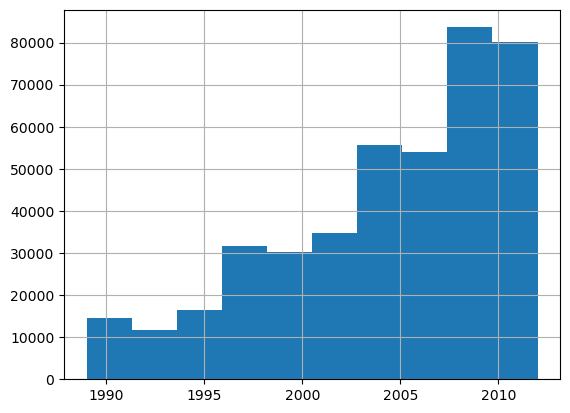

In [39]:
df.saleYear.hist()

### Maybe the older data is not as relevant?  Drop everything <2004

Also not as much of it

In [40]:
filt=df['saleYear']>2004
df=df[filt]
df.reset_index(inplace=True)

In [41]:
df.shape

(238132, 68)

## Prepare the rest of the data (the super easy way)

Use FastAI's TabularPandas class to prepare data

### Dependant var

We are trying to predict 'SalePrice'.  Specifically the root mean squared log error (RMSLE) between the actual and predicted values.  Start by taking the log of the dependant variable (the L of RMSLE) 

start here 4/23/25

In [42]:
df.dtypes

index                         int64
SalesID                      object
SalePrice                    object
MachineID                    object
ModelID                      object
datasource                   object
auctioneerID                 object
YearMade                    float64
MachineHoursCurrentMeter     object
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                

In [43]:
dep_var = 'SalePrice'
#take the log of dependant var since that is what the contest wants
df[dep_var] = np.log(df[dep_var].astype(float))

In [44]:
df['SalePrice']=df['SalePrice'].astype(float)

## Get the indexes of train and test

Its a time series, the latest entries are the test set, the earlier ones, the train set.  Everything later than Oct 2010 is test

In [45]:
len(df)

238132

In [46]:
df.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2012    11573
Name: count, dtype: int64

In [47]:
#what if we just use 2012 as the test?
df.saleYear.value_counts()[2012]/len(df)*100

4.859909629953135

In [48]:
cond = (df.saleYear<2012 ) 
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

### What do they look like BTW

Lets also see what the vix and some commodity prices are

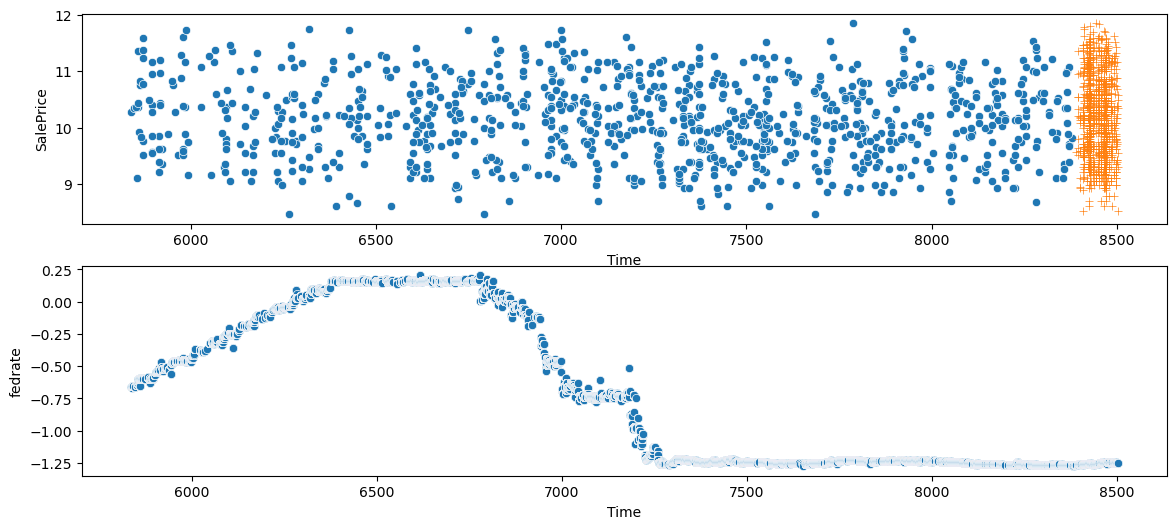

In [49]:
# trn_subset=train_idx[-500:]
# valid_subset=valid_idx[:500]
trn_subset=train_idx
valid_subset=valid_idx
trn_and_valid_subset=np.append(trn_subset,valid_subset)

fig, (ax1,ax4) = plt.subplots(nrows=2,figsize=(14,6))

# the following 2 take a long time to plot we only want to see where they begin and end
trn_subset = np.random.choice(trn_subset, 1000)
valid_subset=np.random.choice(valid_subset, 1000)
_=sns.scatterplot(x=df.iloc[trn_subset].Time, y=df.iloc[trn_subset].SalePrice,ax=ax1,  marker="o")
_=sns.scatterplot(x=df.iloc[valid_subset].Time, y=df.iloc[valid_subset].SalePrice,ax=ax1,  marker="+")

# _=sns.scatterplot(x=df.iloc[trn_and_valid_subset].Time, y=df.iloc[trn_and_valid_subset].vix,ax=ax2,  marker="+")
# _=sns.scatterplot(x=df.iloc[trn_and_valid_subset].Time, y=df.iloc[trn_and_valid_subset].wheat,ax=ax3,  marker="o")
_=sns.scatterplot(x=df.iloc[trn_and_valid_subset].Time, y=df.iloc[trn_and_valid_subset].fedrate,ax=ax4,  marker="o")

In [50]:
#Hmmm looks like there is a bunch of volitility in the fed funds rate until time index 7300 or so
#maybe reinvestigate this training on only 7300 and above?

### Obvious ordinal Categorical

In [51]:
df['ProductSize'].unique()

array(['Large / Medium', 'Medium', 'Small', nan, 'Mini', 'Large',
       'Compact'], dtype=object)

In [52]:
szs=[ 'Large','Large / Medium','Medium','Compact','Small','Mini']
szs_to_i={i:v for v,i in enumerate(szs)}
df['ProductSize'] = df['ProductSize'].map(szs_to_i)

### <mark>What are the other categorical and the continuous variables?

Easy to ID: cat columns are objects or ints with small cardinality, continuous are ints with large cardinality or floats.  

We can get this easily using dtypes and nunique, or we can use a fastai function that does it for us in 1 go.

In [53]:
# using these? 
df.dtypes
# df.nunique()

index                         int64
SalesID                      object
SalePrice                   float64
MachineID                    object
ModelID                      object
datasource                   object
auctioneerID                 object
YearMade                    float64
MachineHoursCurrentMeter     object
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                 float64
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                

In [54]:
#it turns out if a column is of type object then it is automatically interpreted as categorical
#lets try to convert the columns tat are objects (but really numeric) to their respective type

In [55]:
#notice that converting a string to a float throws a ValueError
# df['fiProductClassDesc'].astype(float)

#but a real int or float column does not
# df['MachineID'].astype(float)

#quick and probably dirty conversions
for col in df.columns:
    try:
        df[col]=df[col].astype(float)
    except ValueError:
        pass
    

## Create a tabular dataframe (convenience method in fast ai that will sorta handle categorical, continuous, and NaNs)

In [56]:
df.fiModelDesc

0         EC280LC
1            980B
2            315L
3            416C
4             226
           ...   
238127       D38E
238128       2064
238129       337G
238130        12G
238131       544H
Name: fiModelDesc, Length: 238132, dtype: object

In [57]:
from fastai.tabular.all import *
cont_cat_split??

Signature: cont_cat_split(df, max_card=20, dep_var=None)
Source:   
def cont_cat_split(df, max_card=20, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
        if label in L(dep_var): continue
        if ((pd.api.types.is_integer_dtype(df[label].dtype) and
            df[label].unique().shape[0] > max_card) or
            pd.api.types.is_float_dtype(df[label].dtype)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names
File:      ~/anaconda3/envs/p311/lib/python3.11/site-packages/fastai/tabular/core.py
Type:      function

In [58]:

cont,cat = cont_cat_split(df,max_card=20, dep_var=dep_var)

In [59]:
for c in cont:
    print(f'{c} has {df[c].nunique()} values and is of type {df[c].dtype}')

index has 238132 values and is of type float64
SalesID has 238132 values and is of type float64
MachineID has 205722 values and is of type float64
ModelID has 4760 values and is of type float64
datasource has 6 values and is of type float64
auctioneerID has 30 values and is of type float64
YearMade has 2029 values and is of type float64
MachineHoursCurrentMeter has 15554 values and is of type float64
ProductSize has 6 values and is of type float64
Time has 1711 values and is of type float64
fedrate has 275 values and is of type float64
saleYear has 8 values and is of type float64
saleMonth has 12 values and is of type float64
saleWeek has 53 values and is of type float64
saleDay has 31 values and is of type float64
saleDayofweek has 7 values and is of type float64
saleDayofyear has 360 values and is of type float64
saleIs_month_end has 2 values and is of type float64
saleIs_month_start has 2 values and is of type float64
saleIs_quarter_end has 2 values and is of type float64
saleIs_qua

In [60]:
for c in cat:
    print(f'{c} has {df[c].nunique()} values is of type {df[c].dtype} and has {df[c].isnull().sum()} NaNs')

UsageBand has 3 values is of type object and has 169023 NaNs
fiModelDesc has 4579 values is of type object and has 0 NaNs
fiBaseModel has 1737 values is of type object and has 0 NaNs
fiSecondaryDesc has 170 values is of type object and has 71236 NaNs
fiModelSeries has 126 values is of type object and has 202772 NaNs
fiModelDescriptor has 138 values is of type object and has 182831 NaNs
fiProductClassDesc has 74 values is of type object and has 0 NaNs
state has 53 values is of type object and has 0 NaNs
ProductGroup has 6 values is of type object and has 0 NaNs
ProductGroupDesc has 6 values is of type object and has 0 NaNs
Drive_System has 4 values is of type object and has 178890 NaNs
Enclosure has 6 values is of type object and has 170 NaNs
Forks has 2 values is of type object and has 122546 NaNs
Pad_Type has 4 values is of type object and has 192805 NaNs
Ride_Control has 3 values is of type object and has 152210 NaNs
Stick has 2 values is of type object and has 192805 NaNs
Transmissi

In [61]:
# df.dtypes

### Some transforms for the data

In [62]:
from fastai.tabular.all import *

#Categorify transform- replaces a column with a numeric categorical column
#FillMissing - replaces missing values with median for the column and creates 
#a new Boolean column that is set to True for any row where the value was missing. 
procs = [Categorify, FillMissing]

In [63]:
Categorify??

Init signature: Categorify(self, enc=None, dec=None, split_idx=None, order=None)
Source:        
class Categorify(TabularProc):
    "Transform the categorical variables to something similar to `pd.Categorical`"
    order = 1
    def setups(self, to):
        store_attr(classes={n:CategoryMap(to.iloc[:,n].items, add_na=(n in to.cat_names)) for n in to.cat_names}, but='to')

    def encodes(self, to): to.transform(to.cat_names, partial(_apply_cats, self.classes, 1))
    def decodes(self, to): to.transform(to.cat_names, partial(_decode_cats, self.classes))
    def __getitem__(self,k): return self.classes[k]
File:           ~/anaconda3/envs/p311/lib/python3.11/site-packages/fastai/tabular/core.py
Type:           _TfmMeta
Subclasses:     

## Now lets create a TabularDataFrame that will autotransform columns for our model

Its mostly a wrapper around a DataFrame that does some work for us

In [64]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [65]:
len(to.train),len(to.valid)

(226559, 11573)

In [66]:
#strings still displayed
to.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,auctioneerID_na,MachineHoursCurrentMeter_na,ProductSize_na,index,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,ProductSize,Time,fedrate,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,SalePrice
0,Medium,EC280LC,EC280,#na#,#na#,LC,"Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons",Connecticut,TEX,Track Excavators,#na#,EROPS,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,Manual,#na#,#na#,#na#,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,#na#,#na#,#na#,#na#,#na#,False,False,False,174566.0,1174825.0,1056544.0,22911.0,121.0,3.0,1998.0,4401.0,1.0,5837.0,-0.663350,2005.0,1.0,2.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105315e+09,11.018629
1,Low,980B,980,B,#na#,#na#,Wheel Loader - 275.0 to 350.0 Horsepower,California,WL,Wheel Loader,#na#,OROPS,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,174567.0,1174686.0,1038563.0,3876.0,121.0,3.0,1970.0,3067.0,2.0,5838.0,-0.668860,2005.0,1.0,2.0,11.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105402e+09,9.132379
2,Medium,315L,315,#na#,#na#,L,"Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons",New Jersey,TEX,Track Excavators,#na#,EROPS,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,Steel,24 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,#na#,#na#,#na#,#na#,#na#,False,False,False,174568.0,1174694.0,1018458.0,1133.0,121.0,3.0,1995.0,7835.0,4.0,5840.0,-0.655085,2005.0,1.0,2.0,13.0,3.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105574e+09,10.545341
3,Medium,416C,416,C,#na#,#na#,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,North Carolina,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,True,174569.0,1174885.0,112264.0,3538.0,121.0,3.0,2000.0,2312.0,2.0,5840.0,-0.655085,2005.0,1.0,2.0,13.0,3.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105574e+09,10.126631
4,#na#,226,226,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,Unspecified,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,True,True,174570.0,1399078.0,1398984.0,7009.0,132.0,3.0,2002.0,0.0,2.0,5840.0,-0.655085,2005.0,1.0,2.0,13.0,3.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105574e+09,9.510445


In [67]:
#grab the DataFrame though and you see that its been transformed
to.items.head()
# type(to.items)

,index,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Time,fedrate,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,ProductSize_na
0,174566.0,1174825.0,11.018629,1056544.0,22911.0,121.0,3.0,1998.0,4401.0,3,2339,710,0,0,64,1.0,16,7,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,2,0,0,0,2,19,28,3,2,1,0,0,0,0,0,5837.0,-0.663350,2005.0,1.0,2.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105315e+09,1,1,1
1,174567.0,1174686.0,9.132379,1038563.0,3876.0,121.0,3.0,1970.0,3067.0,2,1652,493,21,0,0,2.0,67,5,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,16,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,5838.0,-0.668860,2005.0,1.0,2.0,11.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105402e+09,1,1,1
2,174568.0,1174694.0,10.545341,1018458.0,1133.0,121.0,3.0,1995.0,7835.0,3,486,164,0,0,63,4.0,9,30,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,0,0,0,2,7,28,3,2,1,0,0,0,0,0,5840.0,-0.655085,2005.0,1.0,2.0,13.0,3.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105574e+09,1,1,1
3,174569.0,1174885.0,10.126631,112264.0,3538.0,121.0,3.0,2000.0,2312.0,3,674,218,30,0,0,2.0,2,33,1,1,4,6,2,2,1,2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5840.0,-0.655085,2005.0,1.0,2.0,13.0,3.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105574e+09,1,1,2
4,174570.0,1399078.0,9.510445,1398984.0,7009.0,132.0,3.0,2002.0,0.0,0,305,100,0,0,0,2.0,39,45,3,3,0,6,1,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,5840.0,-0.655085,2005.0,1.0,2.0,13.0,3.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.105574e+09,1,2,2


In [68]:
#only diff between the tabularpandas and the datafram in terms of columns, note the _na, these are dummy columns that will be set to
#1 if a nan is infered
set(to.items.columns)-set(df.columns)

{'MachineHoursCurrentMeter_na', 'ProductSize_na', 'auctioneerID_na'}

## Lets get our train and test sets

In [69]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [70]:
#dataset for the linear regressor part of the BoostedHybrid model
xs_linreg=xs.loc[:,['Time']]
valid_xs_linreg=valid_xs.loc[:,['Time']]

# Train model

The same one we have been using for other time series analysis, no lags though, they are not appropriate for this problem

In [71]:
from sklearn import linear_model
from catboost import CatBoostRegressor

#if you have optuna trial parameters from below then plug in here (**trial.params,silent=True, random_state=42)
hm=ut.BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(silent=True, random_state=42), num_lags=0)

In [72]:
#fit it
hm.fit(xs_linreg,xs,y)

## Get test set predictions and competition metric error, rmse

In [140]:
# valid_xs.isnull().sum()

In [74]:
#get our target value, the training set for linear regression, and the training set for catboost
#get predictions on test set
preds=hm.predict(valid_xs_linreg,valid_xs,valid_y,False)

Create a function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:

In [144]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
r_mse(preds, valid_y)

0.232765

In [146]:
def get_score(xs=xs, valid_xs=valid_xs, col_to_drop=None):
    """
    Trains the hybrid model and evaluates its performance by calculating the RMSE.

    Parameters:
    xs (DataFrame): Training features.
    valid_xs (DataFrame): Validation features.
    col_to_drop (str or list, optional): Column(s) to drop from the features before training and prediction.

    Returns:
    None: Prints the RMSE score for the model.
    """
    # Train the hybrid model using the training data, dropping the specified column(s) if provided
    hm.fit(xs_linreg, xs.drop(columns=col_to_drop, axis=1) if col_to_drop is not None else xs, y)
    
    # Predict on the validation set, dropping the specified column(s) if provided
    preds = hm.predict(
        valid_xs_linreg, 
        valid_xs.drop(columns=col_to_drop, axis=1) if col_to_drop is not None else valid_xs, 
        valid_y, 
        False
    )
    score= r_mse(preds, valid_y)
    # Print the RMSE score for the model
    print(f'{col_to_drop}: {score}')
    return score
default_score=get_score()
default_score

None: 0.232415


0.232415

# <mark> Permutation Importance 

In [92]:
from sklearn.inspection import permutation_importance
feature_names=valid_xs.columns
result = permutation_importance(
    hm.model_2, valid_xs, valid_y[-len(valid_xs):], n_repeats=10, random_state=42, n_jobs=8, scoring=None)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

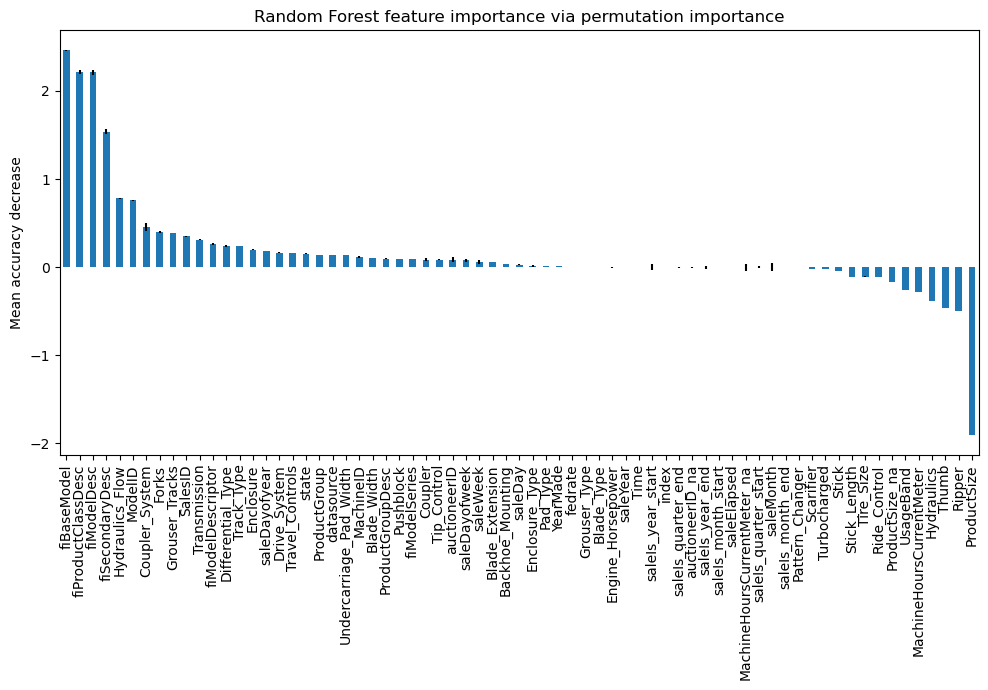

In [93]:
#plot em
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Random Forest feature importance via permutation importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [107]:
#get set of correlated columns
# list(forest_importances[forest_importances<0].index)
# set([col for pair in corcols for col in pair])


In [136]:
#lets get rid of all importences <0 IFF those columns are not correlated with other columns

def get_cols_to_drop(corcols,forest_importances, fi_threshold=0.0): 
    '''
    corcols: columns that are correlated with other columns
    forest_importances: columns that have a low importance score
    '''
    #get the columns that are correlated with other columns
    corcols = set([col for pair in corcols for col in pair])
    
    #get the columns that are not important
    lfi=forest_importances[forest_importances<fi_threshold].index
    
    #get the columns that are not correlated and not important
    cols_to_drop=set(lfi) - corcols
    
    return cols_to_drop
corcols=ut.get_correlated_columns(xs,correlation_threshold=.80)
cols_to_drop=get_cols_to_drop(corcols,forest_importances)
print(f"Columns to drop: {cols_to_drop}")


Columns to drop: {'Hydraulics', 'UsageBand', 'MachineHoursCurrentMeter', 'MachineHoursCurrentMeter_na', 'ProductSize_na', 'Ripper', 'saleIs_quarter_start', 'saleIs_month_end', 'ProductSize'}


In [149]:
#there are a bunch of <0 permutation importances,lets drop 1 at a time and see how our score is affected
def drop_1_col_at_a_time(vals, default_score=default_score):
    """
    Drop one column at a time from the DataFrame and calculate the RMSE score.

    Parameters:
    vals (list): List of columns to drop.

    Returns:
    None: Prints the RMSE score for each column dropped.
    """
    for col in vals:
        if(get_score(col_to_drop=col)<default_score):
            print(f"Column {col} should be dropped")

# drop_1_col_at_a_time(forest_importances[forest_importances<0.0].index, default_score)

In [128]:
#lets drop em in the train and validation set
xs_perm = xs.drop(columns=cols_to_drop)
valid_xs_perm= valid_xs.drop(columns=cols_to_drop)

In [ ]:
#see what it is with all the importances <0 dropped
# get_score(xs,valid_xs)
get_score(xs_perm,valid_xs_perm)

None: 0.239673


## Lets see if we can drop any corelated columns

In [151]:
#lets get a list of highly correlated columns to drop
corcols=ut.get_correlated_columns(xs,correlation_threshold=.80)
l=[]
dontdrop=['Time']
for col in corcols:
    if col[0] in dontdrop:
        continue
    l.append(col[0])
l=list(set(l))
print(l)

#then drop them from train and test and see how that affects model
# df.drop(columns=l, inplace=True)



['Grouser_Tracks', 'Stick_Length', 'Undercarriage_Pad_Width', 'Coupler', 'ProductGroupDesc', 'Hydraulics_Flow', 'Blade_Width', 'Enclosure_Type', 'Travel_Controls', 'Blade_Type', 'Tip_Control', 'fiBaseModel', 'Engine_Horsepower', 'saleDayofyear', 'Scarifier', 'saleElapsed', 'Stick', 'saleWeek', 'Thumb', 'Turbocharged', 'saleYear', 'fedrate', 'Pushblock', 'Grouser_Type', 'Differential_Type', 'Pattern_Changer']


In [150]:
#there are a bunch of correlations,lets drop 1 at a time and see how our score is affected
drop_1_col_at_a_time(l, default_score)

Grouser_Tracks: 0.232278
Column Grouser_Tracks should be dropped
Stick_Length: 0.234715
Undercarriage_Pad_Width: 0.234657
Coupler: 0.234549
ProductGroupDesc: 0.233176
Hydraulics_Flow: 0.233229
Blade_Width: 0.23394
Enclosure_Type: 0.232727
Travel_Controls: 0.233405
Blade_Type: 0.232445
Tip_Control: 0.233608
fiBaseModel: 0.23409
Engine_Horsepower: 0.233184
saleDayofyear: 0.233521
Scarifier: 0.232935
saleElapsed: 0.234207
Stick: 0.232755
saleWeek: 0.235026
Thumb: 0.234477
Turbocharged: 0.233142
saleYear: 0.233387
fedrate: 0.233413
Pushblock: 0.233747
Grouser_Type: 0.233901
Differential_Type: 0.233294
Pattern_Changer: 0.233612


In [ ]:
#Steering_Controls will be dropped
xs.drop(columns=['Grouser_Tracks'], inplace=True)
valid_xs.drop(columns=['Grouser_Tracks'], inplace=True)

xs.drop(columns=['Steering_Controls'], inplace=True)
valid_xs.drop(columns=['Steering_Controls'], inplace=True)


In [ ]:
#score with none dropped
get_score()

None: 0.232278


0.232278

# Not bad, and this is before we do any other data augmentaton or hyperparameter tuning using Optuna

<mark>Also this score would place in 8th out of 474 teams IFF our validation set is like the test set that only Kaggle has (not likely).


### Maybe we can fine tune the catboost regressor?

In [ ]:
#see what we have now, helps set ranges for optuna
# hm.model_2.get_all_params()

In [ ]:
%%time
from sklearn.metrics import mean_squared_error
import optuna
import sklearn
def objective(trial):
    #these are the parameters I want to optimize
    params = {
        'learning_rate':trial.suggest_discrete_uniform("learning_rate", 0.001, 0.11, 0.001),
        'depth': trial.suggest_int("depth", 1, 12),
        'l2_leaf_reg':trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'iterations':1000,
        'silent':True,
        'random_state':42
    }
 
    # Define the model. Pass in params to be tuned
    clf=ut.BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(**params), num_lags=0)
    
    #fit it
    clf.fit(xs_linreg,xs_perm,y)
    
    #get preds
    preds=clf.predict(valid_xs_linreg,valid_xs_perm,valid_y,False)

    return r_mse(preds,valid_y)
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

trial = study.best_trial

print('root_mean_squared_error: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
#plug these into model above and try again
trial.params

In [ ]:
#not satisfied?  Keep on optimizing from where you left off above
study.optimize(objective, n_trials=10)

In [ ]:
#how would this do?
#if you have optuna trial parameters from below then plug in here (**trial.params,silent=True, random_state=42)
hm=ut.BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(**trial.params,silent=True, random_state=42), num_lags=0)
hm.fit(xs_linreg,xs_perm,y)
preds=hm.predict(valid_xs_linreg,valid_xs_perm,valid_y,False)
print(f' {r_mse(preds, valid_y)}')

## The best score from above Optuna run is 0.237569

<mark>This is pretty good given the best Kaggle score is .22909.  This score would put us in 16th place

## How would a plain boosted tree do?

In [ ]:
from catboost import CatBoostRegressor
clf1 = CatBoostRegressor(**trial.params,silent=True, random_state=42)
clf1.fit(xs_perm,y)
preds1=clf1.predict(valid_xs_perm)
r_mse(preds1,valid_y)

## How about a random Forest?

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf2 = RandomForestRegressor(n_estimators=100, random_state=42)
clf2.fit(xs_perm, y)
preds2=clf2.predict(valid_xs_perm)
r_mse(preds2,valid_y)

## Whats next? 

Making several models and averageing their results.  This is called bagging.  The problem is that we dont want to combine a Boosted tree with a random forest since the boosted tree is usually a little better so the random forest will probably just make things worse.

A better idea is to average 2 different kinds of models, like a neural network and a boosted tree.  But thats a topic for another class

### Lets see if there is domain shift in our train and test set

(rewrite this)
Idealy the train set is distributed exactly like the valid set.  If it isn't then you can probably train a random forest to predict whether a row is in training or validation set.

If any columns are important in this prediction then they are useful for determing which set rows are in.  Think about getting rid of those columns

In [155]:
from sklearn.ensemble import RandomForestClassifier
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

df_dom = pd.concat([xs_perm, valid_xs_perm])    #first concatenate em all together
is_valid = np.array([0]*len(xs_perm) + [1]*len(valid_xs_perm))  #is it in train set or valid set?

In [171]:
#train
m = RandomForestClassifier(n_estimators=100, random_state=42,oob_score=True)
m.fit(df_dom, is_valid)

RandomForestClassifier(oob_score=True, random_state=42)

In [172]:
#looks like its pretty accurate
m.oob_score_

0.9529966573161104

In [173]:
#whats important?
rf_feat_importance(m, df_dom)[:15]

,cols,imp
46,YearMade,0.187807
47,MachineHoursCurrentMeter,0.110954
45,auctioneerID,0.091493
44,ModelID,0.077254
1,fiModelDesc,0.075697
2,fiBaseModel,0.060500
6,fiProductClassDesc,0.041496
10,Enclosure,0.040181
3,fiSecondaryDesc,0.035181
42,MachineHoursCurrentMeter_na,0.025318


saleyear, saleelapsed,time and index  are all important for seeing whether the data is in the train or the test.  Which is expected, anything after 2012 is test before is train, the rest pretty much encodes this information as well

Lets drop those columns and then see how it does

In [169]:
colstodrop=rf_feat_importance(m, df_dom)[:1].iloc[:,0].to_list()
# colstodrop=['saleDay']

In [170]:
df_dom.drop(columns=colstodrop, inplace=True)